In [5]:

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [6]:
# 1. Data Collection: Download stock price data
ticker = 'AAPL'  # Example: Apple Inc.
start_date = '2015-01-01'
end_date = '2023-01-01'


In [7]:
# Fetch stock data from Yahoo Finance
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Use only the closing price for LSTM
stock_data = stock_data[['Close']]
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed

                Close
Date                 
2015-01-02  27.332500
2015-01-05  26.562500
2015-01-06  26.565001
2015-01-07  26.937500
2015-01-08  27.972500


In [8]:
# Scale data between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

# Split data into training (80%) and test (20%)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [9]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] to fit into LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [10]:
# 3. LSTM Model Creation

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0434
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0875e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8658e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1887e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9459e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0678e-04
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1602e-04
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2094e-04
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0290e-04
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1650e-04
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3631e-04
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1280e-04
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5175e-04
Epoch 15/50
25/25 ━━━━━━━━━━

In [11]:
# 4. Model Prediction and Visualization

# Make predictions using the test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions to get original price scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform the actual prices
y_train_inverse = scaler.inverse_transform([y_train])
y_test_inverse = scaler.inverse_transform([y_test])


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


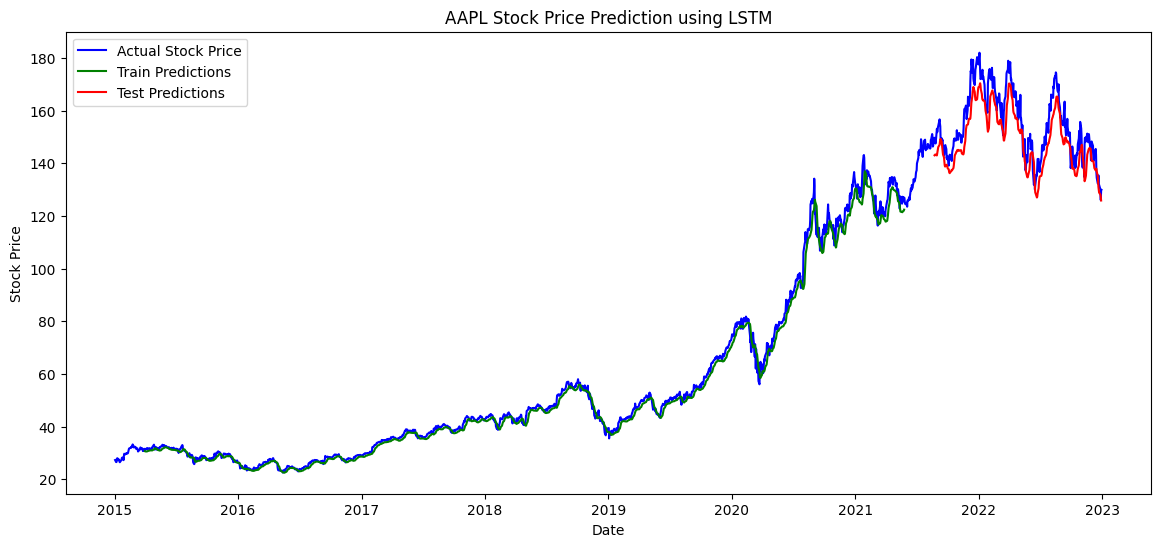

In [14]:
# Plot training and test predictions
plt.figure(figsize=(14, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Actual Stock Price', color='blue')
plt.plot(stock_data.index[time_step:len(train_predict) + time_step], train_predict, label='Train Predictions', color='green')

# Adjust the starting index for test predictions to match the length of test_predict
# The end index was off by one, causing the dimension mismatch
plt.plot(stock_data.index[len(train_data) + time_step: len(train_data) + time_step + len(test_predict)],
         test_predict, label='Test Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'{ticker} Stock Price Prediction using LSTM')
plt.legend()
plt.show()

In [15]:
# Compute RMSE for train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train_inverse[0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(y_test_inverse[0], test_predict[:, 0]))
print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 2.5152261417271427
Testing RMSE: 7.717324524521077
